In [145]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/future-crop-submissions/lstm_3ep_maize_submission.csv
/kaggle/input/future-crop-submissions/last_loc_3ep_maize_submission.csv
/kaggle/input/future-crop-submissions/wheat_train_context.csv
/kaggle/input/future-crop-submissions/wheat_test_context.csv
/kaggle/input/future-crop-submissions/ealstm_1ep_maize_submission.csv
/kaggle/input/future-crop-submissions/maize_train_context.csv
/kaggle/input/future-crop-submissions/solutions.csv
/kaggle/input/future-crop-submissions/lstm_submission.csv
/kaggle/input/future-crop-submissions/last_loc_6ep_maize_submission.csv
/kaggle/input/future-crop-submissions/lstm_5ep_maize_submission.csv
/kaggle/input/future-crop-submissions/maize_test_context.csv


In [146]:
maize_test_context = pd.read_csv('/kaggle/input/future-crop-submissions/maize_test_context.csv')
maize_train_context = pd.read_csv('/kaggle/input/future-crop-submissions/maize_train_context.csv')

wheat_test_context = pd.read_csv('/kaggle/input/future-crop-submissions/wheat_test_context.csv')
wheat_train_context = pd.read_csv('/kaggle/input/future-crop-submissions/wheat_train_context.csv')

lstm_submission = pd.read_csv('/kaggle/input/future-crop-submissions/last_loc_6ep_maize_submission.csv')
solutions = pd.read_csv('/kaggle/input/future-crop-submissions/solutions.csv')

In [147]:
len(lstm_submission), len(solutions)

(691271, 1245149)

In [148]:
merged = pd.merge(lstm_submission, solutions, how='inner', on='ID',suffixes=('_lstm','_sol'))
merged_with_context = pd.merge(merged, maize_test_context, on='ID', suffixes=('', '_context'))
locations = list(merged_with_context.groupby(['lat','lon']).groups.keys())

nrows = 6
ncols = 4

random_indexes = np.random.randint(0,len(locations),nrows*ncols)

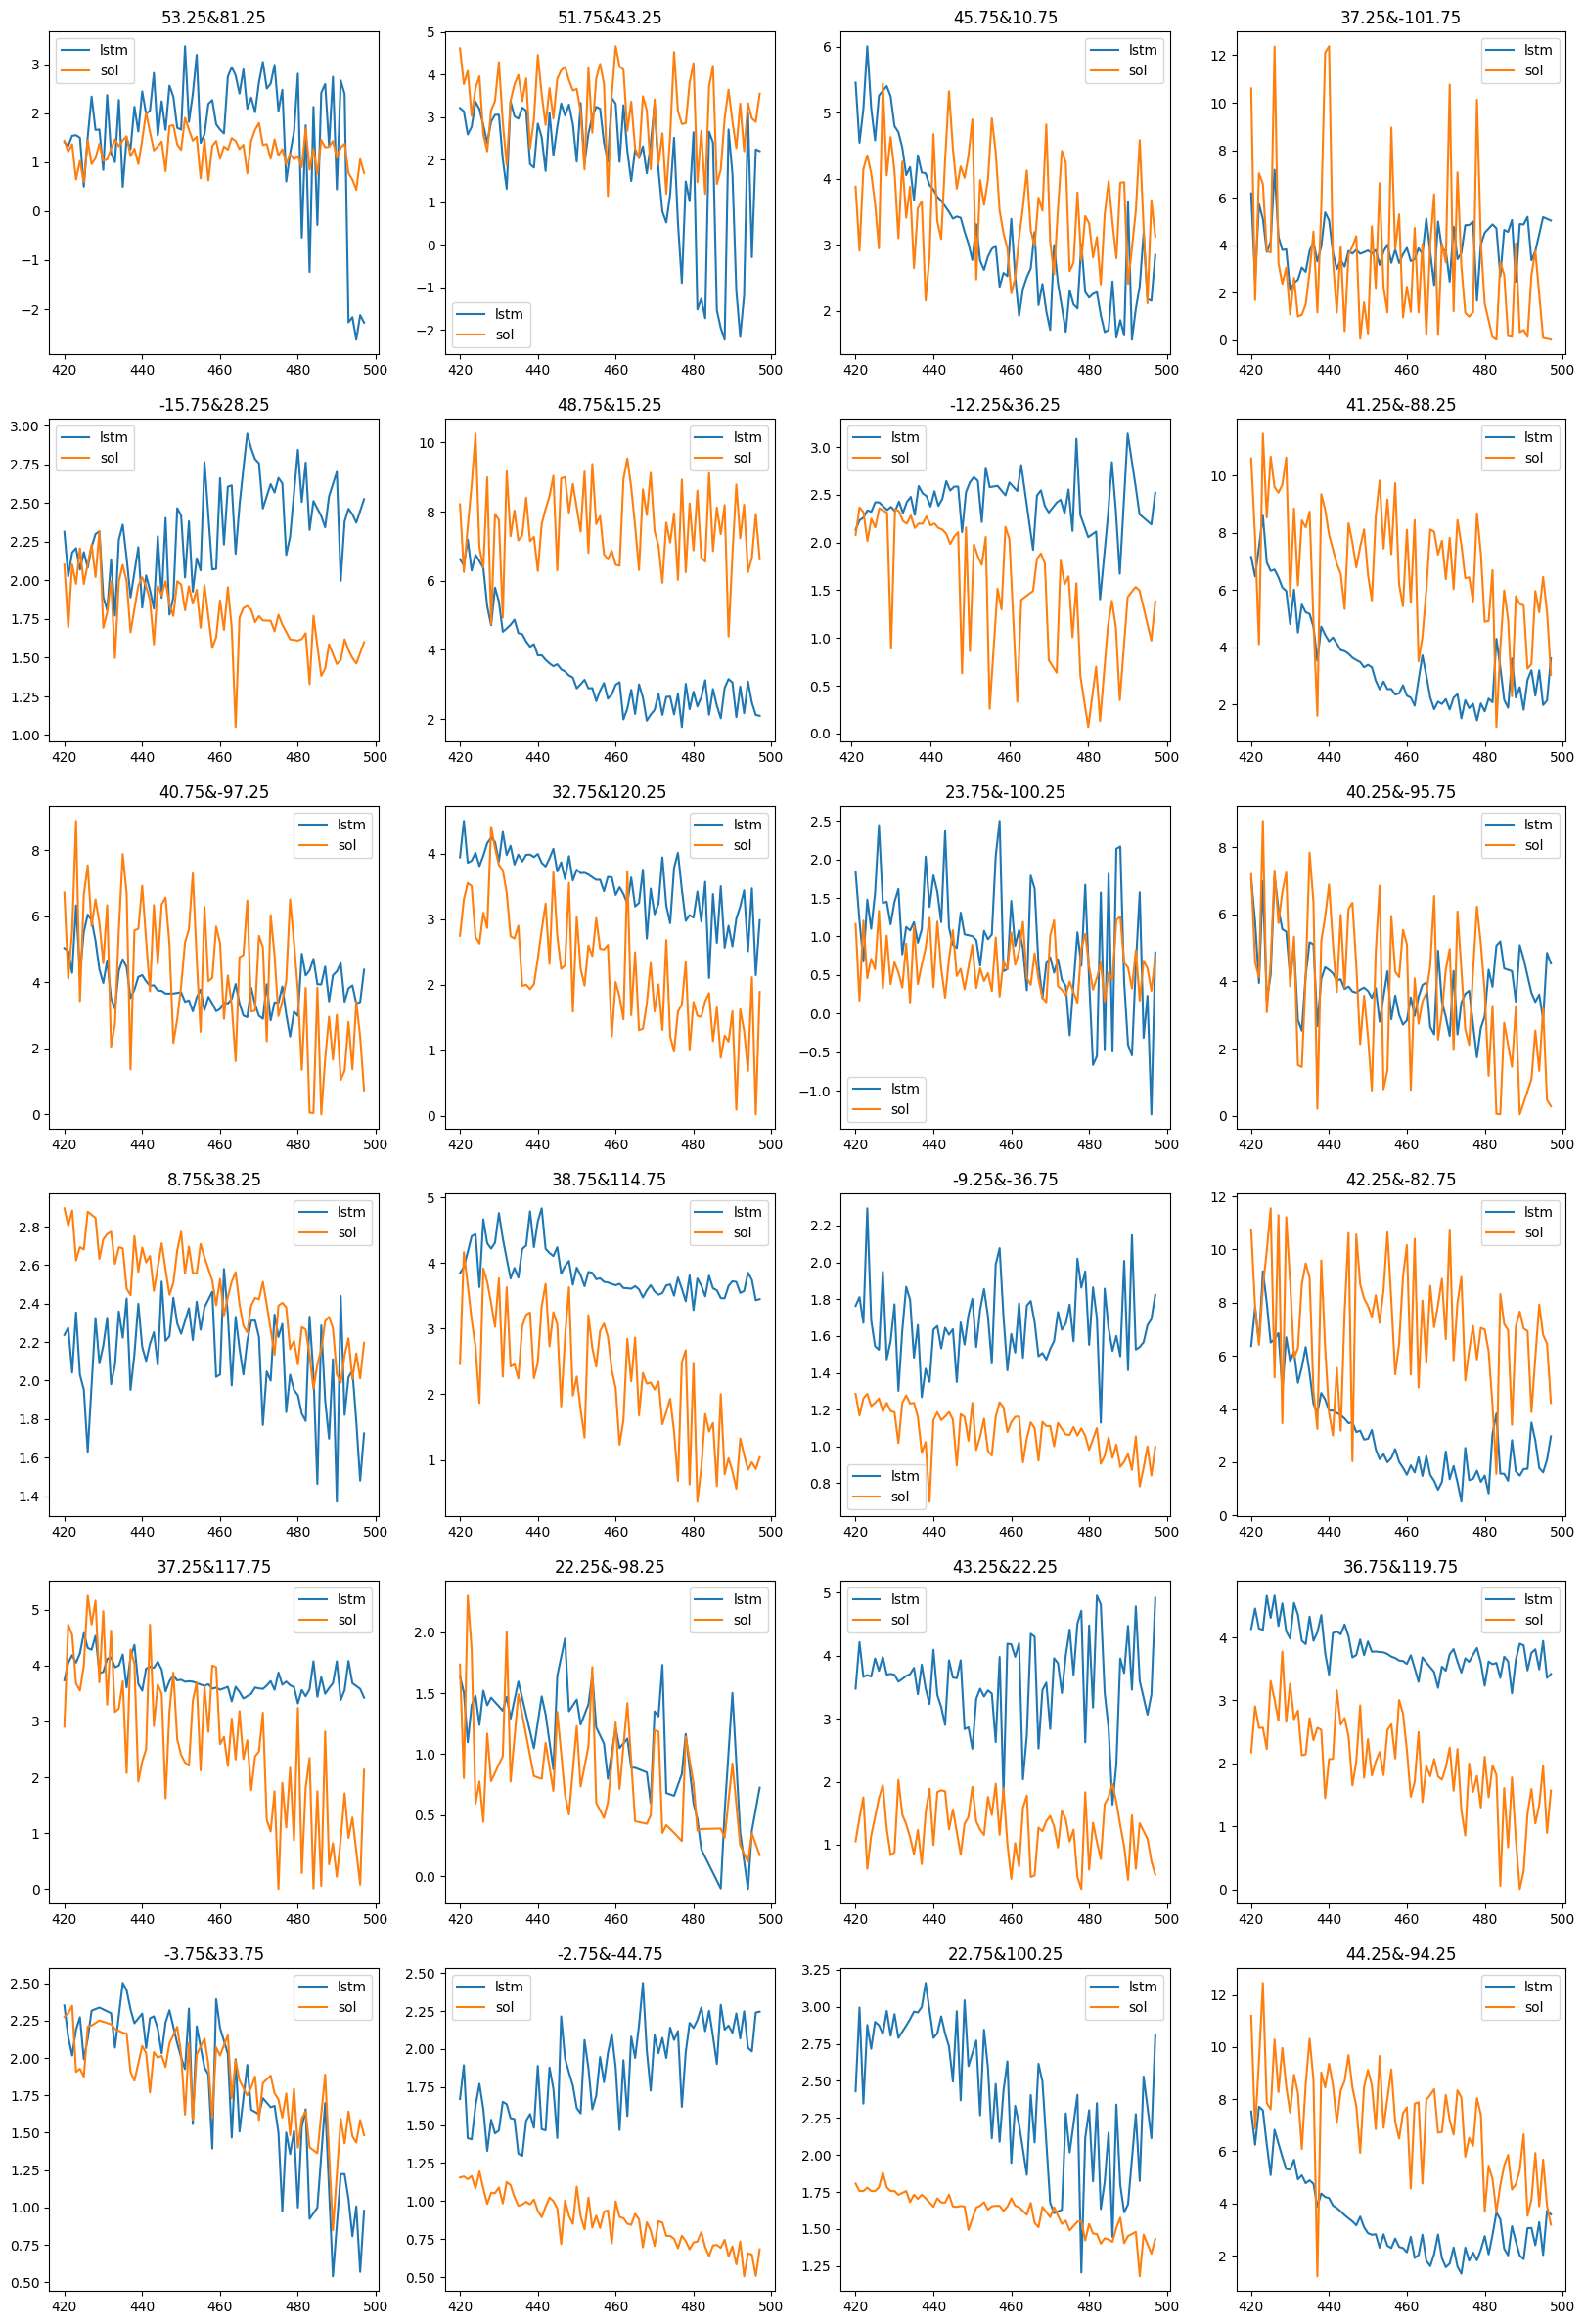

In [149]:
c = merged_with_context

fig, axes = plt.subplots(nrows,ncols,figsize=(ncols*5,nrows*5))
for i, ax in enumerate(axes.flatten()):
    r = random_indexes[i]
    lat, lon = locations[r]
    index_list = c[(c['lat']==lat) & (c['lon']==lon)].index.values
    years = c[(c['lat']==lat) & (c['lon']==lon)].year.values
    data = c[c.index.isin(index_list)]

    x = data['year'].values
    y1 = data['yield_lstm'].values
    y2 = data['yield_sol'].values

    ax.plot(x,y1, label='lstm')
    ax.plot(x,y2, label='sol')
    ax.set_title(f'{lat}&{lon}')
    ax.legend()

plt.show()

In [31]:
# np.var(merged_with_context.yield_sol)

4.475221302524586

In [151]:
merged_with_context['mse'] = (merged_with_context.yield_lstm - merged_with_context.yield_sol)**2

In [163]:
merged_with_context['yield_sol_var'] = merged_with_context['yield_sol'].copy()
merged_with_context['yield_sol_mean'] = merged_with_context['yield_sol'].copy()

In [164]:
np.sqrt(np.mean(merged_with_context.mse.values))

1.890622414197688

In [165]:
r2 = merged_with_context.groupby(['lat','lon']).agg({'mse':'mean', 'yield_sol_var':'var', 'yield_sol_mean':'mean'})

In [167]:
r2['yield_sol_var_corr'] = r2['yield_sol_var'].transform(lambda x: max(x, 1e-6))
r2['r2'] = 1 - r2['mse']/r2['yield_sol_var_corr']

In [173]:
(r2['r2']>0).sum()/len(r2), r2['r2'].mean(), r2['r2'].min(), r2['r2'].max()

(0.06643018381167365,
 -23.880102498229814,
 -26470.11867173383,
 0.814558506335756)

In [177]:
# r2['r2'] = r2['yield_sol']

,mse_x,yield_sol_var_x,yield_sol_mean_x,yield_sol_var_corr_x,r2_x,mse_y,yield_sol_var_y,yield_sol_mean_y,yield_sol_var_corr_y,r2_y
lat,,,,,,,,,,
-38.75,7.818818,7.836871,5.802065,7.836871,0.002304,7.818818,7.836871,5.802065,7.836871,0.002304
-38.75,7.818818,7.836871,5.802065,7.836871,0.002304,12.398179,9.338055,6.555909,9.338055,-0.327705
-38.75,7.818818,7.836871,5.802065,7.836871,0.002304,13.734234,12.533761,6.129724,12.533761,-0.095779
-38.75,12.398179,9.338055,6.555909,9.338055,-0.327705,7.818818,7.836871,5.802065,7.836871,0.002304
-38.75,12.398179,9.338055,6.555909,9.338055,-0.327705,12.398179,9.338055,6.555909,9.338055,-0.327705
...,...,...,...,...,...,...,...,...,...,...
58.25,1.102679,0.059416,1.173000,0.059416,-17.558620,3.655397,0.034034,0.781282,0.034034,-106.404527
58.25,1.102679,0.059416,1.173000,0.059416,-17.558620,1.994602,0.059643,1.146897,0.059643,-32.442264
58.25,1.102679,0.059416,1.173000,0.059416,-17.558620,2.545152,0.050079,0.963590,0.050079,-49.822480


In [169]:
r2.sort_values(by='r2')[:10]

,,mse,yield_sol_var,yield_sol_mean,yield_sol_var_corr,r2
lat,lon,,,,,
27.75,100.25,14.296988,0.000540,0.116729,0.000540,-26470.118672
-11.75,27.75,2.437940,0.000224,0.050667,0.000224,-10866.490178
21.75,93.25,2.604677,0.000289,0.172000,0.000289,-9006.529975
21.25,93.25,2.184465,0.000244,0.211619,0.000244,-8957.321640
50.75,118.75,8.277313,0.001270,0.249959,0.001270,-6516.649624
-1.75,37.25,2.009003,0.000726,0.291731,0.000726,-2766.154849
27.25,100.25,11.555432,0.005608,0.329148,0.005608,-2059.617776
46.25,13.75,10.088425,0.007905,0.350577,0.007905,-1275.161861
-1.75,37.75,1.632288,0.001379,0.394831,0.001379,-1182.779004


In [170]:
r2.sort_values(by='yield_sol_mean')[:10]

,,mse,yield_sol_var,yield_sol_mean,yield_sol_var_corr,r2
lat,lon,,,,,
-11.75,27.75,2.437940,0.000224,0.050667,0.000224,-10866.490178
27.75,100.25,14.296988,0.000540,0.116729,0.000540,-26470.118672
3.75,40.75,0.984847,0.004684,0.122627,0.004684,-209.257873
-13.75,-45.25,2.369489,0.045665,0.134276,0.045665,-50.888933
21.75,93.25,2.604677,0.000289,0.172000,0.000289,-9006.529975
31.25,-9.75,0.145898,0.015151,0.196491,0.015151,-8.629431
-10.75,26.75,0.930084,0.030895,0.200800,0.030895,-29.104982
21.25,93.25,2.184465,0.000244,0.211619,0.000244,-8957.321640
18.75,-90.75,1.014421,0.025035,0.211908,0.025035,-39.519471


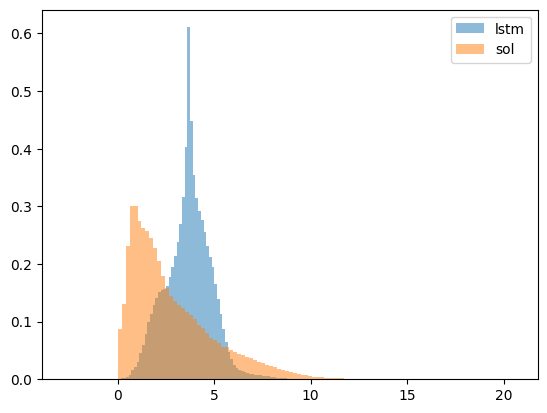

In [18]:
plt.hist(merged.yield_lstm, bins=100, label='lstm', density=True, alpha=0.5)
plt.hist(merged.yield_sol, bins=100, label='sol', density=True, alpha=0.5)
plt.legend()
plt.show()

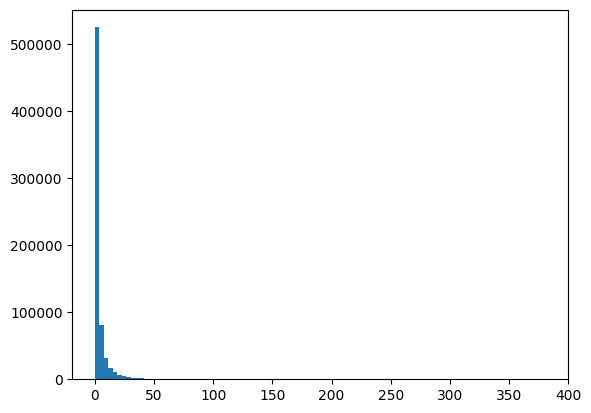

In [45]:
plt.hist(merged.mse,bins=100)
plt.show()

In [21]:
np.sqrt(merged[merged.mse<10]['mse'].mean())

1.6459661505511165